In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch                                             # PyTorch - machine learning framework
import torch.nn as nn                                    # neural network
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 

In [2]:
# I think split_series function is the same as split_data function - take note when implementing into Python
def split_data(data, input_size, output_size, train_ratio, seed):
    X, y = [], [] 
    total_size = input_size + output_size
    for i in range(len(data) - total_size + 1):
        X.append(features[i:i + input_size])                            
        y.append(target[i + input_size:i + total_size])        
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

In [3]:
# Data Handling - should be the same as our linear version
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
data = Bitcoin.iloc[:, 4:]

In [4]:
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

In [5]:
# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

In [6]:
X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)

In [7]:
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [8]:
train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [10]:
# Second Best DL Model: Bi-directional Long-Short Term Memory Model (BD-LSTM) Multivariate
class BDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BDLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_sizes[-1] * 2, output_size)  # * 2 because of bidirectional

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc(out[:, -1, :])
        return out

In [11]:
# Hyperparameters
input_size = 6  # Multivariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

In [12]:
# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.006275
Epoch [10/50], Loss: 0.000015
Epoch [20/50], Loss: 0.000022
Epoch [30/50], Loss: 0.000025
Epoch [40/50], Loss: 0.000025
Epoch [50/50], Loss: 0.000024


In [14]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [15]:
## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.014366


In [16]:
## Calculate RMSE at varying time steps 
# Currently displays the model performance for first 3 time steps
# (Advanced: implement this in general form: flexible number of user defined output window size)
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

In [17]:
mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011555
The RMSE at 2nd time step is: 0.013776
The RMSE at 3rd time step is: 0.017200


In [18]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[4039.2244  4105.      4058.8801 ]
 [9591.391   9736.127   9712.651  ]
 [ 613.98315  635.4662   604.16925]
 ...
 [8261.438   8374.556   8390.808  ]
 [ 419.24323  439.25146  408.8799 ]
 [ 512.392    532.70105  502.17758]]
True values: [[ 4278.846    4017.2686   4214.672  ]
 [ 9888.61    10233.6     10975.6    ]
 [  465.321     454.934     456.078  ]
 ...
 [ 8192.494    8144.1943   8827.765  ]
 [  257.321     234.825     233.84299]
 [  320.046     328.206     352.68402]]


In [19]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 429.1063, MAPE on test set: 35.4485%


In [20]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 353.2271 and MAPE: 34.1959%
At time step 2, prediction have MAE: 442.8549 and MAPE: 38.6379%
At time step 3, prediction have MAE: 491.2371 and MAPE: 33.5119%


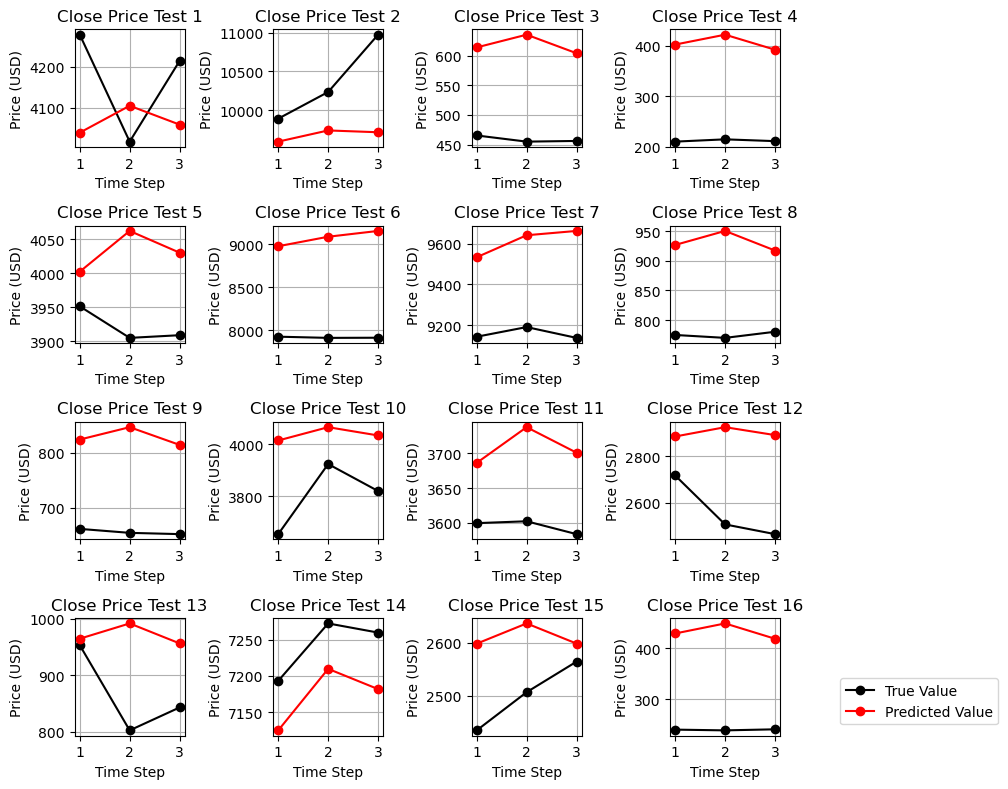

In [21]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(3.0, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [22]:
## BD-LSTM: Quantile Version (Multivariate)

In [23]:
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
data = Bitcoin.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [24]:
class BDLSTM_Quantile(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, num_steps_ahead):
        super(BDLSTM_Quantile, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_size[0], batch_first=True, bidirectional=True))
        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], batch_first=True, bidirectional=True))
        
        # Define separate linear layers for each quantile
        self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, self.num_steps_ahead) for _ in range(num_quantiles)])

    def forward(self, x):
        for lstm in self.lstms:
            x, _ = lstm(x)
        
        lstm_out = x[:, -1, :]  # Use the output of the last time step
        
        # Compute the outputs for each quantile
        quantile_outputs = [fc(lstm_out) for fc in self.fc]
        
        # Stack the quantile outputs
        output = torch.stack(quantile_outputs, dim=2)
        return output

In [25]:
# Quantile loss function
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

In [26]:
# Hyperparameters
input_size = 6  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict
output_size = 3

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

In [27]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.063398
Epoch [10/50], Loss: 0.002327
Epoch [20/50], Loss: 0.002096
Epoch [30/50], Loss: 0.002025
Epoch [40/50], Loss: 0.001967
Epoch [50/50], Loss: 0.001916


In [28]:
def evaluate_model(model, test_dataloader, quantiles):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))  # Reshape targets
            outputs = model(inputs)  # Forward pass
            all_preds.append(outputs)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return all_preds, all_targets

In [29]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)

In [30]:
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [31]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

In [32]:
## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.030410
Quantile 0.25: 0.017866
Quantile 0.50: 0.014147
Quantile 0.75: 0.015658
Quantile 0.95: 0.025512


In [33]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

In [34]:
mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011044
The RMSE at 2nd time step is: 0.013417
The RMSE at 3rd time step is: 0.017276


In [35]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

In [36]:
# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [4278.846  4017.2686 4214.672 ]
At Quantile 0.05: [3442.9758 3641.7234 3336.6304]
At Quantile 0.25: [3826.8425 3900.5742 3919.1538]
At Quantile 0.5: [3975.8525 3991.3743 4025.8083]
At Quantile 0.75: [4043.0188 4100.335  4118.5283]
At Quantile 0.95: [4476.8237 4468.4224 4603.0337]
Actual Values: [ 9888.61 10233.6  10975.6 ]
At Quantile 0.05: [8415.558 8472.84  8183.102]
At Quantile 0.25: [9233.993 9249.129 9142.186]
At Quantile 0.5: [9462.639  9516.819  9529.1045]
At Quantile 0.75: [ 9800.098  9724.702 10031.094]
At Quantile 0.95: [10583.765 10742.828 11041.992]
Actual Values: [465.321 454.934 456.078]
At Quantile 0.05: [217.0355  350.1188  251.55998]
At Quantile 0.25: [392.45044 420.91272 419.4701 ]
At Quantile 0.5: [416.20364 419.10663 426.48154]
At Quantile 0.75: [443.60626 456.30386 439.96417]
At Quantile 0.95: [648.1963  501.23282 609.64655]
Actual Values: [210.33899 214.861   211.315  ]
At Quantile 0.05: [ 13.617284 137.42899

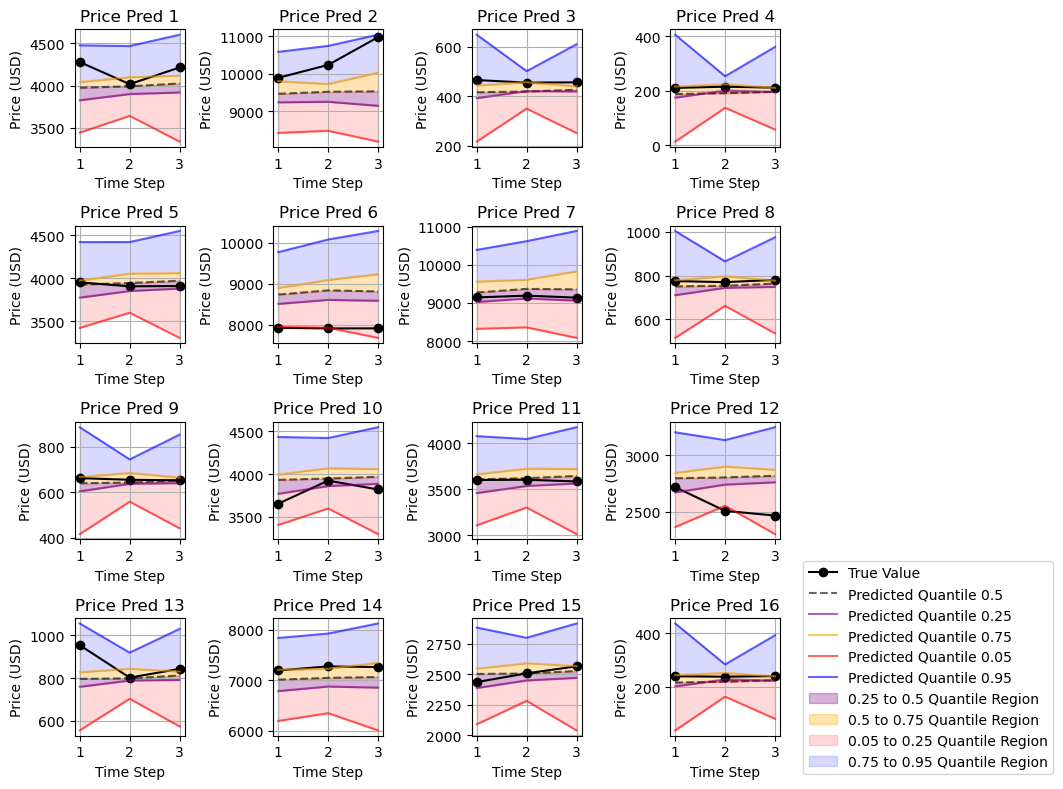

In [37]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [38]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 327.6974, MAPE: 6.1501%


In [39]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 253.3981 and MAPE: 5.8459%
At time step 2, prediction have MAE: 325.0258 and MAPE: 6.2153%
At time step 3, prediction have MAE: 404.6680 and MAPE: 6.3891%


In [40]:
## Data: Multivariate BTC
## Best Performing Model: Encoder-Decoder Long Short Term Memory Model (ED-LSTM)

In [41]:
# Data handling
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
data = Bitcoin.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features)  # normalize input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1)  # normalize output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

def split_data(features, target, input_steps, output_steps, train_ratio, seed):
    X, y, decoder_inputs = [], [], []
    total_size = input_steps + output_steps
    for i in range(len(features) - total_size + 1):
        X.append(features[i:i + input_steps])
        y.append(target[i + input_steps:i + total_size])
        decoder_inputs.append(target[i + input_steps - 1:i + input_steps + output_steps - 1])
    
    X_train, X_test, y_train, y_test, decoder_inputs_train, decoder_inputs_test = train_test_split(
        X, y, decoder_inputs, train_size=train_ratio, random_state=seed
    )
    return X_train, X_test, y_train, y_test, decoder_inputs_train, decoder_inputs_test

class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, decoder_inputs, outputs):
        self.inputs = inputs
        self.decoder_inputs = decoder_inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        decoder_input = self.decoder_inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(decoder_input, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

input_steps = 5
output_steps = 3
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test, decoder_inputs_train, decoder_inputs_test = split_data(
    features, target, input_steps, output_steps, train_ratio, seed
)

train_dataset = Time_Series_Dataset(X_train, decoder_inputs_train, y_train)
test_dataset = Time_Series_Dataset(X_test, decoder_inputs_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, (hidden, cell) = self.lstm(x, (hidden, cell))
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        out, (hidden, cell) = self.lstm(x, (hidden, cell))
        out = self.fc(out)
        return out, hidden, cell

class EncoderDecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(EncoderDecoderLSTM, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(1, hidden_size, output_size, num_layers)

    def forward(self, encoder_inputs, decoder_inputs):
        hidden, cell = self.encoder(encoder_inputs)
        decoder_inputs = decoder_inputs.unsqueeze(-1)  # Add feature dimension to decoder inputs
        outputs, hidden, cell = self.decoder(decoder_inputs, hidden, cell)
        return outputs

In [43]:
# Training loop
input_size = 6  # number of features
hidden_size = 100
output_size = 1  # predicting 1 value per time step
num_layers = 1
input_steps = 5
output_steps = 3

model = EncoderDecoderLSTM(input_size, hidden_size, output_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for encoder_inputs, decoder_inputs, targets in train_dataloader:
        
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]
        
        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(batch_size, input_steps, input_size)
        decoder_inputs = decoder_inputs.view(batch_size, output_steps)  # Output steps dimension only
        targets = targets.view(batch_size, output_steps, 1)  # Add feature dimension
        
        # Forward pass
        outputs = model(encoder_inputs, decoder_inputs)
        
        # Reshape outputs to match targets
        outputs = outputs.view(batch_size, output_steps, output_size)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [1/50], Loss: 0.005850
Epoch [10/50], Loss: 0.000026
Epoch [20/50], Loss: 0.000034
Epoch [30/50], Loss: 0.000030
Epoch [40/50], Loss: 0.000024
Epoch [50/50], Loss: 0.000019


In [44]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for encoder_inputs, decoder_inputs, targets in test_dataloader:
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]
        
        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(batch_size, input_steps, input_size)
        decoder_inputs = decoder_inputs.view(batch_size, output_steps)  # Output steps dimension only
        targets = targets.view(batch_size, output_steps, 1)  # Add feature dimension
        
        # Forward pass
        outputs = model(encoder_inputs, decoder_inputs)
        
        # Reshape outputs to match targets
        outputs = outputs.view(batch_size, output_steps, output_size)
        
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays and remove last dimension
y_pred = np.concatenate(y_pred, axis=0).squeeze(-1)
y_test = np.concatenate(y_test, axis=0).squeeze(-1)


In [45]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.013003


In [46]:
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011182
The RMSE at 2nd time step is: 0.012355
The RMSE at 3rd time step is: 0.015150


In [47]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[4026.7168  4085.9485  4135.155  ]
 [9501.182   9681.695   9768.152  ]
 [ 506.37973  483.53882  572.6218 ]
 ...
 [8199.895   8298.414   8313.1    ]
 [ 299.61926  273.87192  364.71048]
 [ 398.3656   370.45175  459.59714]]
True values: [[ 4278.846    4017.2686   4214.672  ]
 [ 9888.61    10233.6     10975.6    ]
 [  465.321     454.934     456.078  ]
 ...
 [ 8192.494    8144.1943   8827.765  ]
 [  257.321     234.825     233.84299]
 [  320.046     328.206     352.68402]]


In [48]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 342.4547, MAPE on test set: 16.8386%


In [49]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 284.2624 and MAPE: 14.3590%
At time step 2, prediction have MAE: 325.0938 and MAPE: 10.5587%
At time step 3, prediction have MAE: 418.0078 and MAPE: 25.5982%


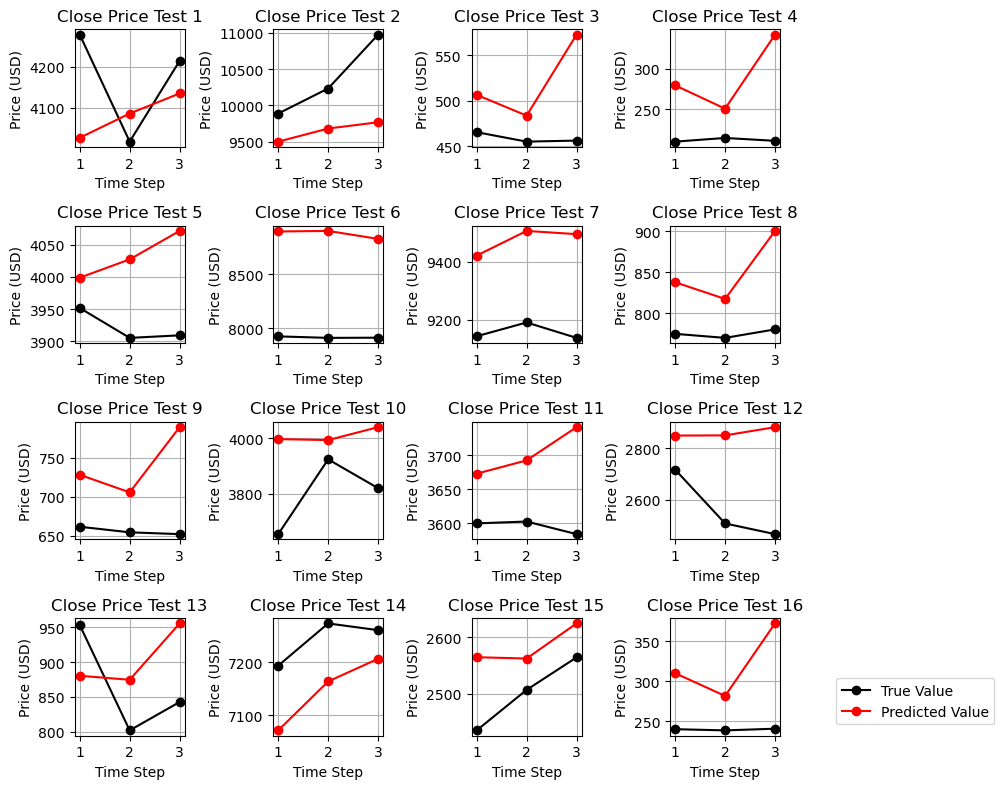

In [50]:
time_steps = list(range(1, output_steps + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [51]:
## ED-LSTM: Multivariate BTC Quantile Ver
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
data = Bitcoin.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features)  # normalize input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1)  # normalize output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

input_steps = 5
output_steps = 3
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test, decoder_inputs_train, decoder_inputs_test = split_data(
    features, target, input_steps, output_steps, train_ratio, seed
)

train_dataset = Time_Series_Dataset(X_train, decoder_inputs_train, y_train)
test_dataset = Time_Series_Dataset(X_test, decoder_inputs_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [52]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, (hidden, cell) = self.lstm(x, (hidden, cell))
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_quantiles):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * num_quantiles)
        self.num_quantiles = num_quantiles

    def forward(self, x, hidden, cell):
        out, (hidden, cell) = self.lstm(x, (hidden, cell))
        out = self.fc(out)
        out = out.view(out.size(0), out.size(1), self.num_quantiles)
        return out, hidden, cell

class EncoderDecoderLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_quantiles):
        super(EncoderDecoderLSTM, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(output_size, hidden_size, output_size, num_quantiles)

    def forward(self, encoder_inputs, decoder_inputs):
        hidden, cell = self.encoder(encoder_inputs)
        decoder_inputs = decoder_inputs.unsqueeze(-1)  # Add feature dimension to decoder inputs
        outputs, hidden, cell = self.decoder(decoder_inputs, hidden, cell)
        return outputs

In [53]:
def quantile_loss(preds, targets, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

In [54]:
# Define our parameters
input_size = len(features[0])
output_size = 1  # Predicting one value per time step
hidden_size = 100
num_layers = 2
num_quantiles = 5
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
output_steps = 3

model = EncoderDecoderLSTM(input_size, output_size, hidden_size, num_layers, num_quantiles)

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for encoder_inputs, decoder_inputs, targets in train_dataloader:
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]

        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(batch_size, input_steps, input_size)
        decoder_inputs = decoder_inputs.view(batch_size, output_steps)
        targets = targets.view(batch_size, output_steps, 1)  # Add feature dimension

        # Forward pass
        outputs = model(encoder_inputs, decoder_inputs)

        # Reshape outputs to match targets
        outputs = outputs.view(batch_size, output_steps, num_quantiles)
        targets = targets.repeat(1, 1, num_quantiles)  # Expand targets to match the number of quantiles

        # Compute loss
        loss = quantile_loss(outputs, targets, quantiles)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.012992
Epoch [10/50], Loss: 0.000403
Epoch [20/50], Loss: 0.000490
Epoch [30/50], Loss: 0.000506
Epoch [40/50], Loss: 0.000542
Epoch [50/50], Loss: 0.000537


In [55]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for encoder_inputs, decoder_inputs, targets in test_dataloader:
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]

        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(batch_size, input_steps, input_size)
        decoder_inputs = decoder_inputs.view(batch_size, output_steps)
        targets = targets.view(batch_size, output_steps, 1)  # Add feature dimension

        # Forward pass
        outputs = model(encoder_inputs, decoder_inputs)
        outputs = outputs.view(batch_size, output_steps, num_quantiles)  # Reshape outputs

        y_pred.append(outputs.numpy())
        y_test.append(targets.repeat(1, 1, num_quantiles).numpy())  # Expand targets to match the number of quantiles

# Convert lists to numpy arrays
predicted_values = np.concatenate(y_pred, axis=0)
actual_values = np.concatenate(y_test, axis=0)[:, :, 0]

In [56]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.027028
Quantile 0.25: 0.016120
Quantile 0.50: 0.012932
Quantile 0.75: 0.014492
Quantile 0.95: 0.023684


In [57]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011363
The RMSE at 2nd time step is: 0.012134
The RMSE at 3rd time step is: 0.015012


In [58]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [4278.846  4017.2686 4214.672 ]
At Quantile 0.05: [3601.4966 3616.4844 3542.5244]
At Quantile 0.25: [3935.6748 3974.9697 3930.236 ]
At Quantile 0.5: [3991.647  4034.598  4002.8699]
At Quantile 0.75: [4088.6926 4168.924  4160.803 ]
At Quantile 0.95: [4441.664 4585.915 4622.126]
Actual Values: [ 9888.61 10233.6  10975.6 ]
At Quantile 0.05: [8480.728 8543.837 8477.43 ]
At Quantile 0.25: [9207.571 9338.077 9354.61 ]
At Quantile 0.5: [9398.411 9534.214 9600.541]
At Quantile 0.75: [9688.992 9891.187 9994.212]
At Quantile 0.95: [10416.914 10774.095 10964.461]
Actual Values: [465.321 454.934 456.078]
At Quantile 0.05: [366.50507 359.35727 357.85904]
At Quantile 0.25: [444.51654 438.91727 438.74103]
At Quantile 0.5: [427.9206  420.35544 422.89935]
At Quantile 0.75: [446.79742 447.07062 455.3475 ]
At Quantile 0.95: [536.77844 540.19556 549.8835 ]
Actual Values: [210.33899 214.861   211.315  ]
At Quantile 0.05: [160.13614 150.439   153.0108 

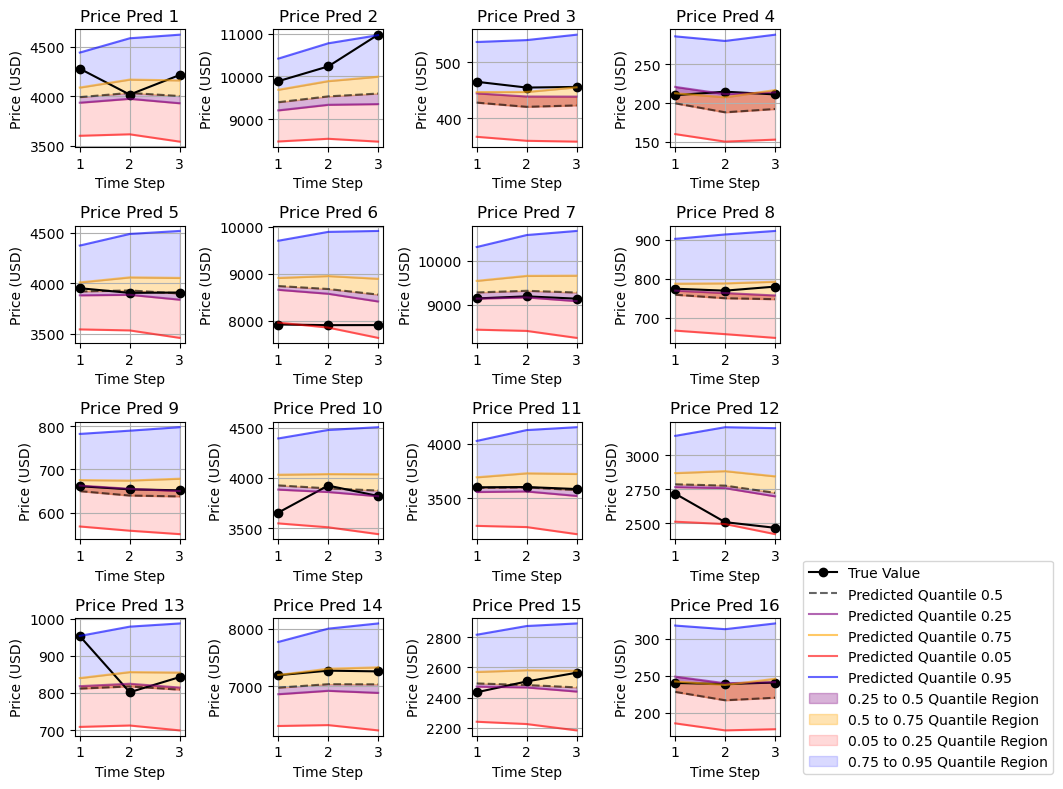

In [59]:
time_steps = list(range(1, output_steps + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [60]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Multivariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Multivariate Quantile Regression Average Performance
MAE: 299.5064, MAPE: 5.7474%


In [61]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 256.2666 and MAPE: 4.3523%
At time step 2, prediction have MAE: 296.0648 and MAPE: 6.3568%
At time step 3, prediction have MAE: 346.1878 and MAPE: 6.5331%


In [62]:
## Dataset: Ethereum (Multivariate)
## Second Best Performing Model: Conv-LSTM

In [63]:
# ED-LSTM used special cases of these, just defining the original version here again
def split_data(data, input_size, output_size, train_ratio, seed):
    X, y = [], [] 
    total_size = input_size + output_size
    for i in range(len(data) - total_size + 1):
        X.append(features[i:i + input_size])                            
        y.append(target[i + input_size:i + total_size])        
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [64]:
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
data = Ethereum.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [65]:
# Convolutional LSTM Model
class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_layers, output_size, num_filters, kernel_size):
        super(ConvLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Convolutional layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(num_filters, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc1 = nn.Linear(hidden_sizes[-1] * 2, 20)  # Fully connected layer
        self.fc2 = nn.Linear(20, output_size)

    def forward(self, x):
        # Convolutional layer expects input of shape (batch_size, in_channels, seq_length)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Convert back to (batch_size, seq_length, num_filters)
        
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = torch.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

In [66]:
# Example usage:
input_size = 6  # univariate 
hidden_sizes = [64, 32]  # Hidden sizes for each LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 3  # 3 steps ahead prediction
num_filters = 64  # Number of filters for Conv1D layer
kernel_size = 2  # Kernel size for Conv1D layer

model = ConvLSTM(input_size, hidden_sizes, num_layers, output_size, num_filters, kernel_size)

In [67]:
# Loss and optimizer - based on related work
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.028613
Epoch [10/50], Loss: 0.000333
Epoch [20/50], Loss: 0.000356
Epoch [30/50], Loss: 0.000360
Epoch [40/50], Loss: 0.000360
Epoch [50/50], Loss: 0.000359


In [68]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.018627


In [69]:
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.014443
The RMSE at 2nd time step is: 0.018050
The RMSE at 3rd time step is: 0.022506


In [70]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[  22.878319   25.264452   27.496098]
 [  24.066523   26.385605   28.565666]
 [1181.2861   1214.4292   1232.6011  ]
 ...
 [ 193.29503   193.824     197.55328 ]
 [ 152.16266   150.71211   152.85434 ]
 [ 128.87973   127.12166   128.30746 ]]
True values: [[  10.3198      11.8640995   11.274799 ]
 [  12.0715      12.035999    11.968999 ]
 [1171.8346    1233.5375    1230.1722   ]
 ...
 [ 173.62134    172.91302    175.53436  ]
 [ 132.24942    127.774124   137.82239  ]
 [ 124.80649    121.2984     122.572296 ]]


In [71]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 35.0027, MAPE on test set: 158.4270%


In [72]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 28.7500 and MAPE: 126.9138%
At time step 2, prediction have MAE: 34.6797 and MAPE: 161.2109%
At time step 3, prediction have MAE: 41.5783 and MAPE: 187.1563%


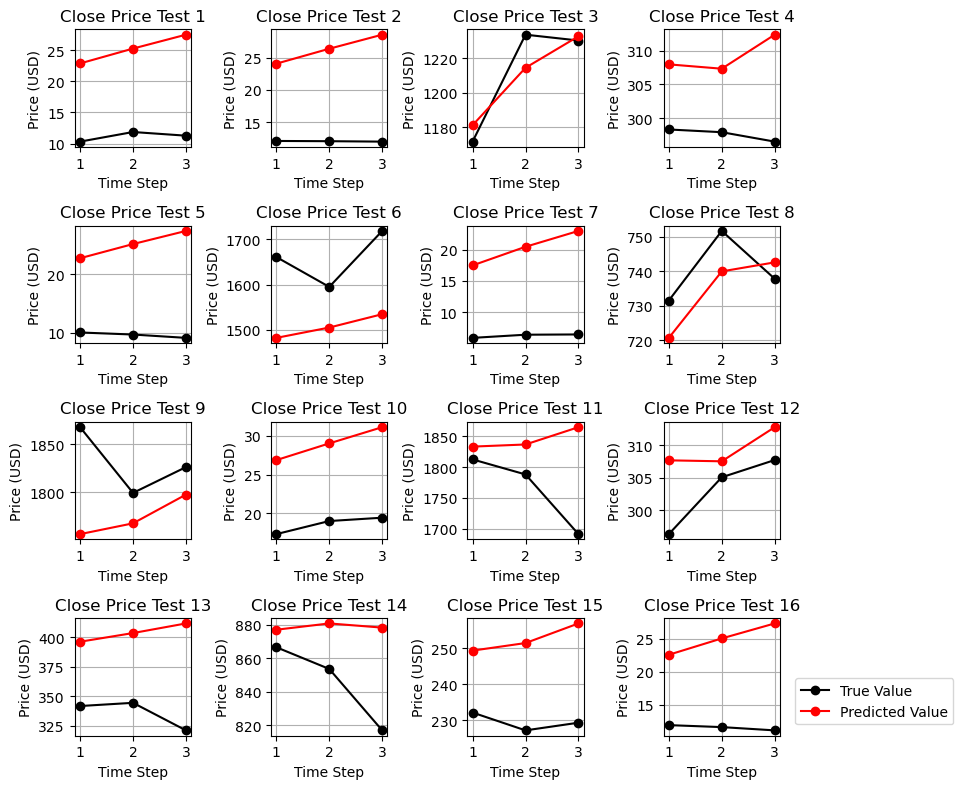

In [73]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(2.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [74]:
# Conv-LSTM Quantile Version (Multivariate)
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
data = Ethereum.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [75]:
# Convolutional LSTM Model for Quantile Regression with Multi-Step Prediction
class Conv_LSTM_Quantile(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_layers, num_quantiles, num_steps_ahead, num_filters, kernel_size):
        super(Conv_LSTM_Quantile, self).__init__()
        self.hidden_size = hidden_sizes
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        # Convolutional layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(num_filters, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_sizes[-1] * 2, num_quantiles) for _ in range(num_steps_ahead)])

    def forward(self, x):
        # Convolutional layer expects input of shape (batch_size, in_channels, seq_length)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Convert back to (batch_size, seq_length, num_filters)
        
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
 
        # Compute the outputs for each step ahead
        step_outputs = [fc(out[:, -1, :]) for fc in self.fc_layers]
        
        # Stack the step outputs
        output = torch.stack(step_outputs, dim=1)  # [batch_size, num_steps_ahead, num_quantiles]
        return output

In [76]:
# Quantile loss function - proven to work (from BD-LSTM Quantile version)
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

In [77]:
input_size = 6  # multivariate
hidden_sizes = [64, 32]  # Hidden sizes for each LSTM layer
num_layers = 2  # Number of LSTM layers
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]  # List of quantiles
num_quantiles = len(quantiles)  # Number of quantiles to predict
num_filters = 64  # Number of filters for Conv1D layer
kernel_size = 2  # Kernel size for Conv1D layer
num_steps_ahead = 3

In [78]:
model = Conv_LSTM_Quantile(input_size, hidden_sizes, num_layers, num_quantiles, num_steps_ahead, num_filters, kernel_size)

In [79]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.040020
Epoch [10/50], Loss: 0.002597
Epoch [20/50], Loss: 0.002420
Epoch [30/50], Loss: 0.002340
Epoch [40/50], Loss: 0.002287
Epoch [50/50], Loss: 0.002250


In [80]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [81]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.040130
Quantile 0.25: 0.021591
Quantile 0.50: 0.019463
Quantile 0.75: 0.025845
Quantile 0.95: 0.038727


In [82]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.015068
The RMSE at 2nd time step is: 0.018546
The RMSE at 3rd time step is: 0.023778


In [83]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [10.3198    11.8640995 11.274799 ]
At Quantile 0.05: [ 9.144081  10.368526   8.4727125]
At Quantile 0.25: [ 7.616623 12.464255 13.369374]
At Quantile 0.5: [14.388183 14.513136 15.606543]
At Quantile 0.75: [15.945113 21.811693 19.456057]
At Quantile 0.95: [19.901419 27.009436 25.030842]
Actual Values: [12.0715   12.035999 11.968999]
At Quantile 0.05: [10.069984 11.213219  9.343585]
At Quantile 0.25: [ 8.665229 13.469918 14.35944 ]
At Quantile 0.5: [15.469257 15.549103 16.591053]
At Quantile 0.75: [17.03431  23.00037  20.580206]
At Quantile 0.95: [21.17454  28.189703 26.306295]
Actual Values: [1171.8346 1233.5375 1230.1722]
At Quantile 0.05: [1025.2019   997.82294 1005.2655 ]
At Quantile 0.25: [1132.9908 1137.9618 1134.5433]
At Quantile 0.5: [1184.3651 1216.3785 1207.0524]
At Quantile 0.75: [1259.148 1258.575 1300.491]
At Quantile 0.95: [1338.9645 1410.8226 1388.7587]
Actual Values: [298.32797 297.92496 296.527  ]
At Quantile 0.05: 

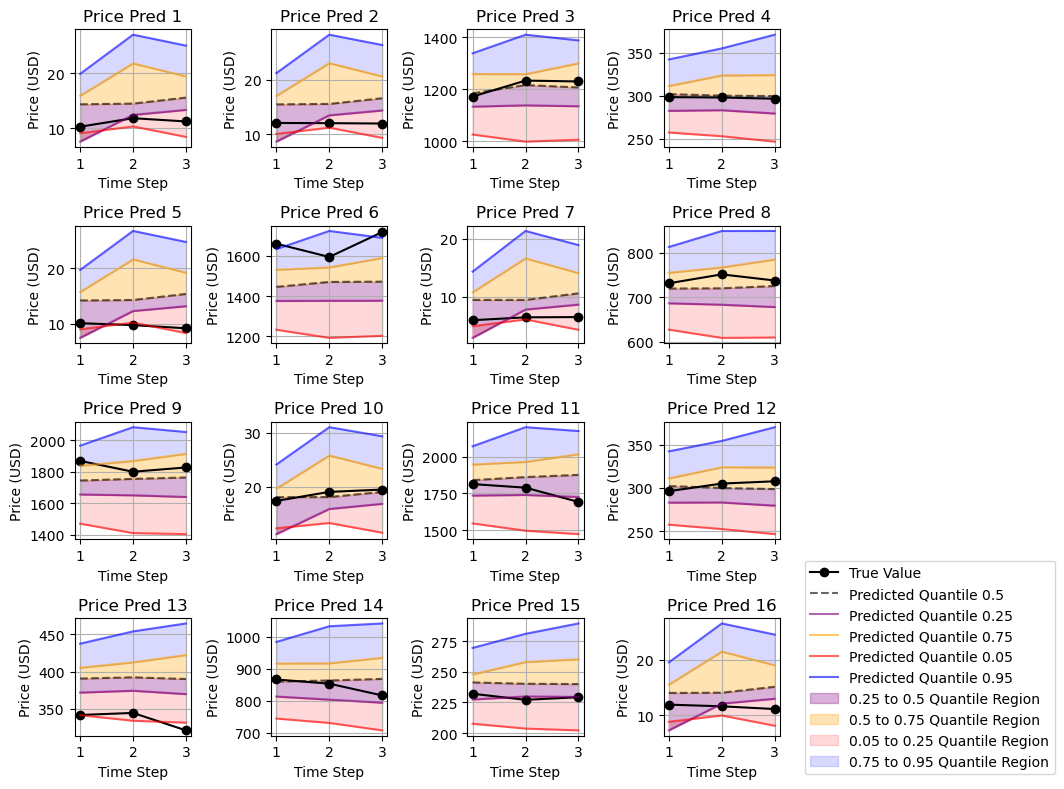

In [84]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [85]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Multivariate Quantile Regression Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Multivariate Quantile Regression Performance
MAE: 31.1444, MAPE: 49.5606%


In [86]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 25.5687 and MAPE: 44.6796%
At time step 2, prediction have MAE: 30.7404 and MAPE: 45.7264%
At time step 3, prediction have MAE: 37.1242 and MAPE: 58.2757%


In [87]:
## Dataset: Ethereum (Multivariate)
## Best Performing Model: Convolutional Neural Network (CNN)
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
data = Ethereum.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [88]:
class CNN(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_steps, input_length):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=kernel_size, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate the final sequence length after convolutions and pooling
        self.final_seq_length = self.calculate_final_seq_length(input_length, kernel_size, padding=1, pool_size=2)
        
        self.fc1 = nn.Linear(num_filters*4 * self.final_seq_length, 20)
        self.fc2 = nn.Linear(20, output_steps)

    def calculate_final_seq_length(self, input_length, kernel_size, padding, pool_size):
        length = input_length
        for _ in range(3):  # 3 convolution + pool layers
            length = (length + 2*padding - (kernel_size - 1) - 1) // 1 + 1  # Convolution
            length = length // pool_size  # Pooling
        return length

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, num_features) -> (batch_size, num_features, seq_length)
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [89]:
# Example usage:
input_size = 6  # Number of input features
num_filters = 64
kernel_size = 2
output_steps = 3  # Number of steps ahead prediction
input_steps = 5  # Length of the input sequence

model = CNN(input_size, num_filters, kernel_size, output_steps, input_steps)

In [90]:
# Loss and optimizer - based on related work
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.014496
Epoch [10/50], Loss: 0.000350
Epoch [20/50], Loss: 0.000331
Epoch [30/50], Loss: 0.000328
Epoch [40/50], Loss: 0.000329
Epoch [50/50], Loss: 0.000333


In [91]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.016684


In [92]:
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.012562
The RMSE at 2nd time step is: 0.017494
The RMSE at 3rd time step is: 0.019266


In [93]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)
# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[   2.472786    30.510954    24.737766 ]
 [   2.8652718   31.141018    25.246092 ]
 [1155.954     1249.1364    1237.2677   ]
 ...
 [ 172.57773    209.61554    199.80058  ]
 [ 129.99919    165.22       155.01212  ]
 [ 106.85477    141.79713    132.14925  ]]
True values: [[  10.3198      11.8640995   11.274799 ]
 [  12.0715      12.035999    11.968999 ]
 [1171.8346    1233.5375    1230.1722   ]
 ...
 [ 173.62134    172.91302    175.53436  ]
 [ 132.24942    127.774124   137.82239  ]
 [ 124.80649    121.2984     122.572296 ]]


In [94]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 35.7331, MAPE on test set: 154.1798%


In [95]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 23.4881 and MAPE: 47.3088%
At time step 2, prediction have MAE: 43.2024 and MAPE: 217.3971%
At time step 3, prediction have MAE: 40.5087 and MAPE: 197.8333%


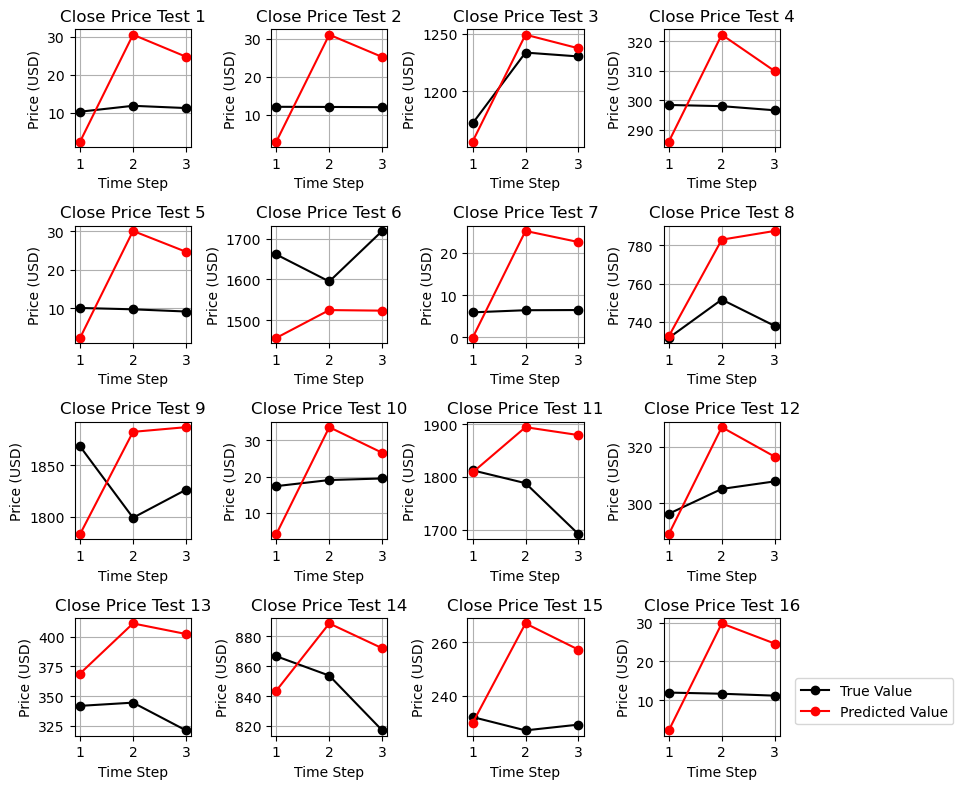

In [96]:
time_steps = list(range(1, output_steps + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(2.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [97]:
## Data: ETH (Multivariate)
## CNN Quantile Version
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
data = Ethereum.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [98]:
class QuantileCNN(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_steps, input_length, num_quantiles):
        super(QuantileCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=kernel_size, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate the final sequence length after convolutions and pooling
        self.final_seq_length = self.calculate_final_seq_length(input_length, kernel_size, padding=1, pool_size=2)
        
        self.fc1 = nn.Linear(num_filters*4 * self.final_seq_length, 20)
        self.fc2 = nn.Linear(20, output_steps * num_quantiles)  # Adjust output size for multiple quantiles

        self.num_quantiles = num_quantiles

    def calculate_final_seq_length(self, input_length, kernel_size, padding, pool_size):
        length = input_length
        for _ in range(3):  # 3 convolution + pool layers
            length = (length + 2*padding - (kernel_size - 1) - 1) // 1 + 1  # Convolution
            length = length // pool_size  # Pooling
        return length

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, num_features) -> (batch_size, num_features, seq_length)
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Reshape output to (batch_size, output_steps, num_quantiles)
        x = x.view(-1, output_steps, self.num_quantiles)
        
        return x

In [99]:
# Quantile loss function
def quantile_loss(preds, targets, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        loss = torch.mean(torch.max((quantile - 1) * errors, quantile * errors))
        losses.append(loss)
    return torch.mean(torch.stack(losses))

In [100]:
# Example usage:
input_size = 6  # Number of input features
num_filters = 64
kernel_size = 2
output_steps = 3  # Number of steps ahead prediction
input_steps = 5  # Length of the input sequence
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]  
num_quantiles = len(quantiles)  

model = QuantileCNN(input_size, num_filters, kernel_size, output_steps, input_steps, num_quantiles)

In [101]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        targets = targets.unsqueeze(-1).expand(-1, -1, num_quantiles) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.044696
Epoch [10/50], Loss: 0.003116
Epoch [20/50], Loss: 0.002328
Epoch [30/50], Loss: 0.002254
Epoch [40/50], Loss: 0.002167
Epoch [50/50], Loss: 0.002097


In [102]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.034115
Quantile 0.25: 0.017074
Quantile 0.50: 0.016982
Quantile 0.75: 0.021566
Quantile 0.95: 0.036183


In [103]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.012315
The RMSE at 2nd time step is: 0.016340
The RMSE at 3rd time step is: 0.021132


In [104]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [10.3198    11.8640995 11.274799 ]
At Quantile 0.05: [ 4.496147   7.7862706 -6.2144475]
At Quantile 0.25: [11.684307  8.769515 13.319693]
At Quantile 0.5: [17.527245 18.617746 14.075464]
At Quantile 0.75: [ 5.2130127 24.261429  13.710494 ]
At Quantile 0.95: [28.745451 20.791512 34.433514]
Actual Values: [12.0715   12.035999 11.968999]
At Quantile 0.05: [ 5.4830756  8.699514  -5.1830153]
At Quantile 0.25: [12.843565  10.261569  14.5856905]
At Quantile 0.5: [18.822218 19.810265 15.015622]
At Quantile 0.75: [ 6.5067124 25.528515  15.011756 ]
At Quantile 0.95: [30.14086  21.641296 36.01835 ]
Actual Values: [1171.8346 1233.5375 1230.1722]
At Quantile 0.05: [1001.82465 1004.6344   956.6835 ]
At Quantile 0.25: [1168.9016 1127.1339 1135.875 ]
At Quantile 0.5: [1203.5327 1233.6838 1240.5105]
At Quantile 0.75: [1223.811  1285.2351 1280.7596]
At Quantile 0.95: [1346.33   1395.397  1427.5828]
Actual Values: [298.32797 297.92496 296.527  ]
At 

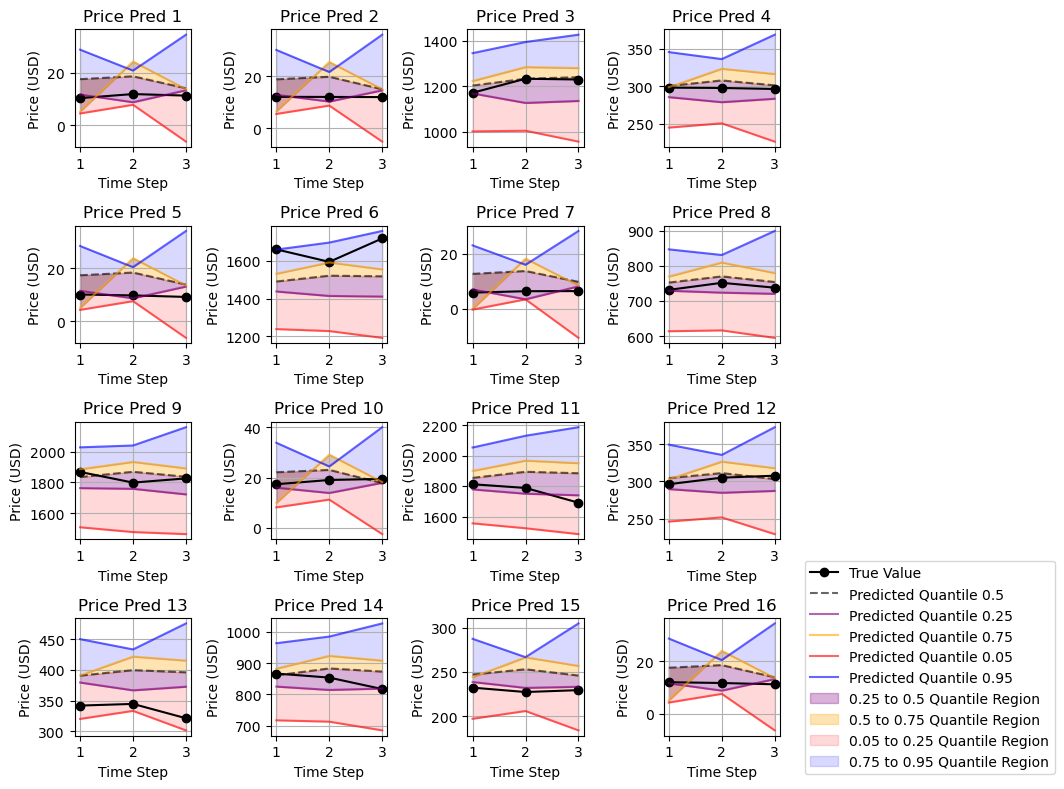

In [105]:
time_steps = list(range(1, output_steps + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [106]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Multivariate Quantile Regression Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Multivariate Quantile Regression Performance
MAE: 30.6301, MAPE: 76.0358%


In [107]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 24.1235 and MAPE: 84.1252%
At time step 2, prediction have MAE: 32.6199 and MAPE: 90.4772%
At time step 3, prediction have MAE: 35.1469 and MAPE: 53.5049%
